In [ ]:
# See requirements.txt to set up your dev environment.
import os
import sys
import utm
import json
import scipy
import overpy
import urllib
import datetime 
import urllib3
import rasterio
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from osgeo import gdal
from planet import api
from planet.api import filters
from traitlets import link
from rasterio.mask import mask
#import rasterio.tools.mask as rio_mask
from shapely.geometry import mapping, shape
from IPython.display import display, Image, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from scipy import ndimage
import warnings
from osgeo import gdal


from osmapi import OsmApi
from geopy.geocoders import Nominatim

urllib3.disable_warnings()
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

%matplotlib inline
# will pick up api_key via environment variable PL_API_KEY
# but can be specified using `api_key` named argument
api_keys = json.load(open("apikeys.json",'r'))
client = api.ClientV1(api_key=api_keys["PLANET_API_KEY"])
gdal.UseExceptions()
api = overpy.Overpass()

In [ ]:
# Basemap Mosaic (v1 API)
mosaicsSeries = 'global_quarterly_2017q1_mosaic'
# Planet tile server base URL (Planet Explorer Mosaics Tiles)
mosaicsTilesURL_base = 'https://tiles0.planet.com/experimental/mosaics/planet-tiles/' + mosaicsSeries + '/gmap/{z}/{x}/{y}.png'
# Planet tile server url
mosaicsTilesURL = mosaicsTilesURL_base + '?api_key=' + api_keys["PLANET_API_KEY"]
# Map Settings 
# Define colors
colors = {'blue': "#009da5"}
# Define initial map center lat/long
center = [52.96037, -1.164275]
# Define initial map zoom level
zoom = 13
# Set Map Tiles URL
planetMapTiles = TileLayer(url= mosaicsTilesURL)
# Create the map
m = Map(
    center=center, 
    zoom=zoom,
    default_tiles = planetMapTiles # Uncomment to use Planet.com basemap
)
# Define the draw tool type options
polygon = {'shapeOptions': {'color': colors['blue']}}
rectangle = {'shapeOptions': {'color': colors['blue']}} 

# Create the draw controls
# @see https://github.com/ellisonbg/ipyleaflet/blob/master/ipyleaflet/leaflet.py#L293
dc = DrawControl(
    polygon = polygon,
    rectangle = rectangle
)
# Initialize an action counter variable
actionCount = 0
AOIs = {}

# Register the draw controls handler
def handle_draw(self, action, geo_json):
    # Increment the action counter
    global actionCount
    actionCount += 1
    # Remove the `style` property from the GeoJSON
    geo_json['properties'] = {}
    # Convert geo_json output to a string and prettify (indent & replace ' with ")
    geojsonStr = json.dumps(geo_json, indent=2).replace("'", '"')
    AOIs[actionCount] = json.loads(geojsonStr)
    
# Attach the draw handler to the draw controls `on_draw` event
dc.on_draw(handle_draw)
m.add_control(dc)
m


In [ ]:
print(AOIs[1])
myAOI = AOIs[1]["geometry"]

# build a query using the AOI and
# a cloud_cover filter that excludes 'cloud free' scenes

old = datetime.datetime(year=2019,month=7,day=15)

query = filters.and_filter(
    filters.geom_filter(myAOI),
    filters.range_filter('cloud_cover', lt=5),
    filters.date_range('acquired', gt=old)
)

# build a request for only PlanetScope imagery
request = filters.build_search_request(
    query, item_types=['PSScene3Band']
)

# if you don't have an API key configured, this will raise an exception
result = client.quick_search(request)
scenes = []
planet_map = {}
for item in result.items_iter(limit=500):
    planet_map[item['id']]=item
    props = item['properties']
    props["id"] = item['id']
    props["geometry"] = item["geometry"]
    props["thumbnail"] = item["_links"]["thumbnail"]
    scenes.append(props)
scenes = pd.DataFrame(data=scenes)
# now let's clean up the datetime stuff
# make a shapely shape from our aoi
portland = shape(myAOI)
footprints = []
overlaps = []
# go through the geometry from our api call, convert to a shape and calculate overlap area.
# also save the shape for safe keeping
for footprint in scenes["geometry"].tolist():
    s = shape(footprint)
    footprints.append(s)
    overlap = 100.0*(portland.intersection(s).area / portland.area)
    overlaps.append(overlap)
# take our lists and add them back to our dataframe
scenes['overlap'] = pd.Series(overlaps, index=scenes.index)
scenes['footprint'] = pd.Series(footprints, index=scenes.index)
# now make sure pandas knows about our date/time columns.
scenes["acquired"] = pd.to_datetime(scenes["acquired"])
scenes["published"] = pd.to_datetime(scenes["published"])
scenes["updated"] = pd.to_datetime(scenes["updated"])

scenes = scenes[scenes['overlap']>0.9]


print(len(scenes))
# now let's clean up the datetime stuff
# make a shapely shape from our aoi
portland = shape(myAOI)
footprints = []
overlaps = []
# go through the geometry from our api call, convert to a shape and calculate overlap area.
# also save the shape for safe keeping
for footprint in scenes["geometry"].tolist():
    s = shape(footprint)
    footprints.append(s)
    overlap = 100.0*(portland.intersection(s).area / portland.area)
    overlaps.append(overlap)
# take our lists and add them back to our dataframe
scenes['overlap'] = pd.Series(overlaps, index=scenes.index)
scenes['footprint'] = pd.Series(footprints, index=scenes.index)
# now make sure pandas knows about our date/time columns.
scenes["acquired"] = pd.to_datetime(scenes["acquired"])
scenes["published"] = pd.to_datetime(scenes["published"])
scenes["updated"] = pd.to_datetime(scenes["updated"])

# first create a list of colors
colors = ["#ff0000","#00ff00","#0000ff","#ffff00","#ff00ff","#00ffff"]
# grab our scenes from the geometry/footprint geojson
footprints = scenes["geometry"].tolist()
# for each footprint/color combo

for footprint,color in zip(footprints,colors):
    # create the leaflet object
    feat = {'geometry':footprint,"properties":{
            'style':{'color': color,'fillColor': color,'fillOpacity': 0.1,'weight': 1}},
            'type':u"Feature"}
    # convert to geojson
    gjson = GeoJSON(data=feat)
    # add it our map
    m.add_layer(gjson)
# now we will draw our original AOI on top 
feat = {'geometry':myAOI,"properties":{
            'style':{'color': "#FFFFFF",'fillColor': "#FFFFFF",'fillOpacity': 0.1,'weight': 2}},
            'type':u"Feature"}
gjson = GeoJSON(data=feat)
m.add_layer(gjson)   
m

In [ ]:

def get_products(client, scene_id, asset_type='PSScene3Band'):    
    """
    Ask the client to return the available products for a 
    given scene and asset type. Returns a list of product 
    strings
    """
    out = client.get_assets_by_id(asset_type,scene_id)
    temp = out.get()
    return temp.keys()

def activate_product(client, scene_id, asset_type="PSScene3Band",product="analytic"):
    """
    Activate a product given a scene, an asset type, and a product.
    
    On success return the return value of the API call and an activation object
    """
    temp = client.get_assets_by_id(asset_type,scene_id)  
    products = temp.get()
    if( product in products.keys() ):
        return client.activate(products[product]),products[product]
    else:
        return None 

def download_and_save(client,product):
    """
    Given a client and a product activation object download the asset. 
    This will save the tiff file in the local directory and return its 
    file name. 
    """
    out = client.download(product)
    fp = out.get_body()
    fp.write()
    return fp.name

def scenes_are_active(scene_list):
    """
    Check if all of the resources in a given list of
    scene activation objects is read for downloading.
    """
    retVal = True
    for scene in scene_list:
        if scene["status"] != "active":
            print("{} is not ready.".format(scene))
            return False
    return True

In [ ]:
to_get = scenes["id"][0:7].tolist()
activated = []
# for each scene to get
for scene in to_get:
    # get the product 
    product_types = get_products(client,scene)
    for p in product_types:
        # if there is a visual product
        if p == "visual": # p == "basic_analytic_dn"
            print("Activating {0} for scene {1}".format(p,scene))
            # activate the product
            _,product = activate_product(client,scene,product=p)
            activated.append(product)

In [9]:

tiff_files = []
asset_type = "_3B_Visual"
# check if our scenes have been activated
if True:#scenes_are_active(activated):
    for to_download,name in zip(activated,to_get):
        # create the product name
        name = name + asset_type + ".tif"
        # if the product exists locally
        if( os.path.isfile(name) ):
            # do nothing 
            print ("We have scene {0} already, skipping...".format(name))
            tiff_files.append(name)
        elif to_download["status"] == "active":
            # otherwise download the product
            print("Downloading {0}....".format(name))
            fname = download_and_save(client,to_download)
            tiff_files.append(fname)
            print("Download done.")
        else:
            print("Could not download, still activating")
else:
    print ("Scenes aren't ready yet")

sorted(tiff_files)
print(tiff_files)

We have scene 20190717_104752_103d_3B_Visual.tif already, skipping...
We have scene 20190717_104751_103d_3B_Visual.tif already, skipping...
We have scene 20190717_090742_0f24_3B_Visual.tif already, skipping...
We have scene 20190715_104258_1012_3B_Visual.tif already, skipping...
We have scene 20190715_104259_1012_3B_Visual.tif already, skipping...
['20190717_104752_103d_3B_Visual.tif', '20190717_104751_103d_3B_Visual.tif', '20190717_090742_0f24_3B_Visual.tif', '20190715_104258_1012_3B_Visual.tif', '20190715_104259_1012_3B_Visual.tif']


In [10]:

infile = tiff_files[0]
# Open the file
gtif = gdal.Open(infile)
# Get the project reference object this knows the UTM zone
reff = gtif.GetProjectionRef()
# arr is the actual image data.
arr = gtif.ReadAsArray()
# Trans is our geo transfrom array. 
trans = gtif.GetGeoTransform()
# print the ref object
print(reff)
# find our UTM zone
i = reff.find("UTM")
print(reff[i:i+12])

PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]
UTM zone 30N


In [11]:

def pixel2utm(ds, x, y):
    """
    Returns utm coordinates from pixel x, y coords
    """
    xoff, a, b, yoff, d, e = ds.GetGeoTransform()
    xp = a * x + b * y + xoff
    yp = d * x + e * y + yoff
    return(xp, yp)

def draw_point(x,y,img):
    t = 20
    # a cloud_cover filter that ex
    img[y-t:y+t,x-t:x+t,:] = [255,0,0]

In [12]:
pos = [3000,1400] # this is the pixel we want info abou
ds = gdal.Open(infile)
# take the GDAL info and make it into UTM
my_utm = pixel2utm(ds,pos[0],pos[1])
# convert UTM into Lat Long
# need to figure out how to get zone info
my_lla = utm.to_latlon(my_utm[0],my_utm[1],30,"N")
# do the lat long look up from OSM
geolocator = Nominatim()
# reverse look up the are based on lat lon
location = geolocator.reverse("{0},{1}".format(my_lla[0],my_lla[1]))
# print location info
print(location.address)
print(location.raw)
# get the OSM ID info
osm_id = int(location.raw["place_id"])
print(osm_id)
# create an interface to the OSM API
MyApi = OsmApi()
# Look up our position 
print(MyApi.NodeGet(osm_id))

C:\Users\mn271\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  if __name__ == '__main__':


18;19, Middle Furlong Gardens, Lace Market, The Meadows, City of Nottingham, East Midlands, England, NG2 1PY, UK
{'place_id': 91210833, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 61738829, 'lat': '52.94260555', 'lon': '-1.15638697007386', 'display_name': '18;19, Middle Furlong Gardens, Lace Market, The Meadows, City of Nottingham, East Midlands, England, NG2 1PY, UK', 'address': {'house_number': '18;19', 'cycleway': 'Middle Furlong Gardens', 'neighbourhood': 'Lace Market', 'suburb': 'The Meadows', 'city': 'City of Nottingham', 'state_district': 'East Midlands', 'state': 'England', 'postcode': 'NG2 1PY', 'country': 'UK', 'country_code': 'gb'}, 'boundingbox': ['52.942544', '52.9426585', '-1.1564727', '-1.1563012']}
91210833
{'id': 91210833, 'visible': True, 'version': 2, 'changeset': 3369526, 'timestamp': datetime.datetime(2009, 12, 14, 7, 41, 14), 'user': 'woodpeck_fixbot', 'uid': 147510, 'lat': 35.17674, 'lon': -119

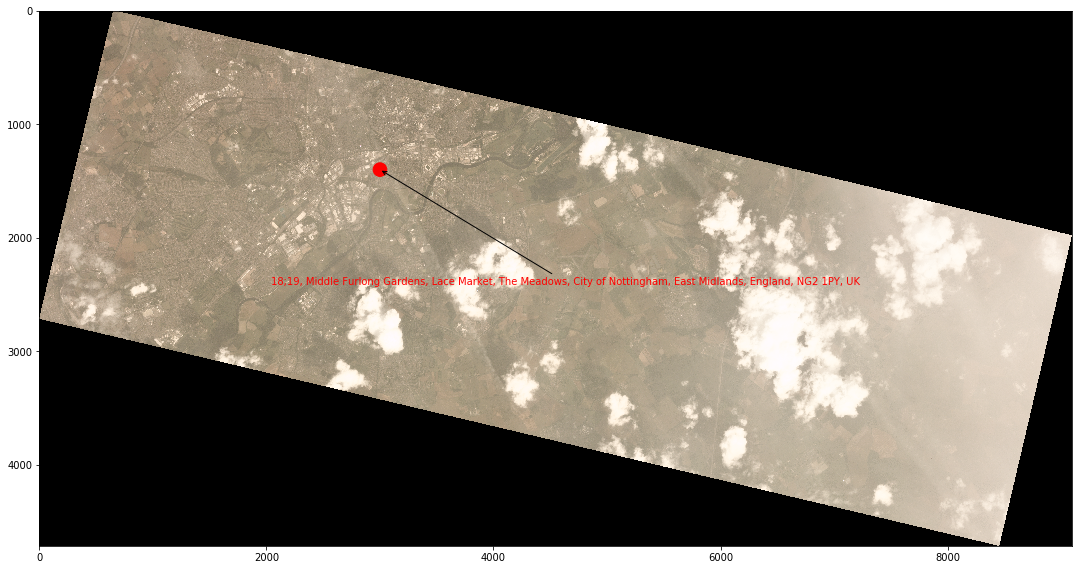

In [13]:

from matplotlib.patches import Circle
fig,ax = plt.subplots(1)

# create our plot
plt.imshow(arr[:3,:,:].transpose((1, 2, 0)))#, extent=extent)
fig = plt.gcf()
# add our annotation
plt.annotate(location.address, xy=pos, xycoords='data',
             xytext=(0.25, 0.5), textcoords='figure fraction',color="red",
             arrowprops=dict(arrowstyle="->"))
ax.set_aspect('equal')
# Set a point
circ = Circle((pos[0],pos[1]),60,color="red")
ax.add_patch(circ)
fig.set_size_inches(18.5, 10.5)
plt.show()

In [14]:

import geopandas as gpd
fname = "./nottinghamUK.geojson"
park_df = gpd.read_file(fname)
portland_parks = json.load(open(fname,'r'))
# raw geojson works better with GDAL
geojson = [p for p in portland_parks["features"]]
# no area out of the box
p = [p.area for p in park_df["geometry"].tolist()]
park_df["area"] = pd.Series(p)
park_df["geojson"] = pd.Series(geojson)
park_df.sort_values(['area',], ascending=[1])
park_df.head()
#len(park_df)
#print park_df["wikipedia"].dropna()

,id,@id,boundary,designation,leisure,name,type,HE_ref,is_in,is_in:city,...,glass_bottles,opening_hours,confetti,description,old_operator,old_use,start_date,geometry,area,geojson
0,relation/551350,relation/551350,reserve,country_park,park,Cotgrave Country Park,multipolygon,None,None,None,...,None,None,None,None,None,None,None,"POLYGON ((-1.0416941 52.9179725, -1.041696 52....",0.000091,"{'type': 'Feature', 'properties': {'@id': 'rel..."
1,way/12342743,way/12342743,None,None,park,Highfields Park,None,1001350,"Nottingham,Nottinghamshire,United Kingdom",Nottingham,...,None,None,None,None,None,None,None,"POLYGON ((-1.1887554 52.9371657, -1.1887225 52...",0.000028,"{'type': 'Feature', 'properties': {'@id': 'way..."
2,way/12342805,way/12342805,None,None,park,Leyton Crescent Recreation Ground,None,None,"Beeston,Nottinghamshire,United Kingdom",None,...,None,None,None,None,None,None,None,"POLYGON ((-1.1953624 52.9173489, -1.195336 52....",0.000005,"{'type': 'Feature', 'properties': {'@id': 'way..."
3,way/12343241,way/12343241,None,None,park,Melbourne Park,None,None,None,None,...,None,None,None,None,None,None,None,"POLYGON ((-1.1896346 52.9698269, -1.1895718 52...",0.000019,"{'type': 'Feature', 'properties': {'@id': 'way..."
4,way/12345070,way/12345070,None,None,park,Broadgate Park,None,None,"Beeston,Nottinghamshire,United Kingdom",None,...,None,None,None,None,None,None,None,"POLYGON ((-1.2115256 52.929064, -1.2114785 52....",0.000002,"{'type': 'Feature', 'properties': {'@id': 'way..."


In [15]:

for p in portland_parks["features"]:
    feat = {'geometry':p["geometry"],"properties":{
            'style':{'color': "#00FF00",'fillColor': "#00FF00",'fillOpacity': 0.0,'weight': 1}},
            'type':u"Feature"}
    # convert to geojson
    gjson = GeoJSON(data=feat)
    # add it our map
    m.add_layer(gjson)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [25]:
park_sz = park_df.groupby("name").sum() 
park_sz = park_sz.sort_values(by='area',ascending=[0])
display(park_sz)

,area
name,
Wollaton Park,2.773131e-04
Holme Pierrepont Country Park,1.757633e-04
University of Nottingham,1.571863e-04
Gedling Country Park,1.291217e-04
Colwick Country Park,1.163415e-04
Cotgrave Country Park,9.096942e-05
Broxtowe Country Park,5.805690e-05
Phoenix Park,5.671984e-05
Bramcote Hills Park,4.052495e-05


In [26]:

def write_geojson_by_name(df,name,outfile):
    """
    Take in a dataframe, a park name, and an output file name 
    Save the park's geojson to the specified file.
    """
    temp = df[df["name"]==name]
    to_write = {"type": "FeatureCollection",
                "features": temp["geojson"].tolist()}
    with open(outfile,'w') as fp:
        fp.write(json.dumps(to_write))
def crop_scenes_to_geojson(geojson,scenes,out_name):
    """
    Take in a geojson file, a list of scenes, and an output name
    Call gdal and warp the scenes to match the geojson file and save the results to outname.
    """
    commands = ["gdalwarp", # t
           "-t_srs","EPSG:3857",
           "-cutline",geojson,
           "-crop_to_cutline",
           "-tap",
            "-tr", "3", "3"
           "-overwrite"]
    for tiff in scenes:
        commands.append(tiff)
    commands.append(out_name)
    print(" ".join(commands))
    subprocess.call(commands)

In [27]:
geo_json_files = []
tif_file_names = []
unique_park_names = list(set(park_df["name"].tolist()))
for name in list(unique_park_names):
    # Generate our file names 
    geojson_name = "./parks/"+name.replace(" ","_")+".geojson"
    tif_name = "./parks/"+name.replace(" ","_")+".tif"
    # write geojson
    write_geojson_by_name(park_df,name,geojson_name)
    # write to park file
    crop_scenes_to_geojson(geojson_name,tiff_files,tif_name)
    # Save the results to lists
    geo_json_files.append(geojson_name)
    tif_file_names.append(tif_name)

gdalwarp -t_srs EPSG:3857 -cutline ./parks/Robin_Hood_Chase_Park.geojson -crop_to_cutline -tap -tr 3 3-overwrite 20190717_104752_103d_3B_Visual.tif 20190717_104751_103d_3B_Visual.tif 20190717_090742_0f24_3B_Visual.tif 20190715_104258_1012_3B_Visual.tif 20190715_104259_1012_3B_Visual.tif ./parks/Robin_Hood_Chase_Park.tif
gdalwarp -t_srs EPSG:3857 -cutline ./parks/Sunninghill_Park.geojson -crop_to_cutline -tap -tr 3 3-overwrite 20190717_104752_103d_3B_Visual.tif 20190717_104751_103d_3B_Visual.tif 20190717_090742_0f24_3B_Visual.tif 20190715_104258_1012_3B_Visual.tif 20190715_104259_1012_3B_Visual.tif ./parks/Sunninghill_Park.tif
gdalwarp -t_srs EPSG:3857 -cutline ./parks/Eastcote_Avenue_Open_Space.geojson -crop_to_cutline -tap -tr 3 3-overwrite 20190717_104752_103d_3B_Visual.tif 20190717_104751_103d_3B_Visual.tif 20190717_090742_0f24_3B_Visual.tif 20190715_104258_1012_3B_Visual.tif 20190715_104259_1012_3B_Visual.tif ./parks/Eastcote_Avenue_Open_Space.tif
gdalwarp -t_srs EPSG:3857 -cutline

gdalwarp -t_srs EPSG:3857 -cutline ./parks/King_George_V_Recreation_Ground.geojson -crop_to_cutline -tap -tr 3 3-overwrite 20190717_104752_103d_3B_Visual.tif 20190717_104751_103d_3B_Visual.tif 20190717_090742_0f24_3B_Visual.tif 20190715_104258_1012_3B_Visual.tif 20190715_104259_1012_3B_Visual.tif ./parks/King_George_V_Recreation_Ground.tif
gdalwarp -t_srs EPSG:3857 -cutline ./parks/Lambley_Lane_Recreation_Ground_(North).geojson -crop_to_cutline -tap -tr 3 3-overwrite 20190717_104752_103d_3B_Visual.tif 20190717_104751_103d_3B_Visual.tif 20190717_090742_0f24_3B_Visual.tif 20190715_104258_1012_3B_Visual.tif 20190715_104259_1012_3B_Visual.tif ./parks/Lambley_Lane_Recreation_Ground_(North).tif
gdalwarp -t_srs EPSG:3857 -cutline ./parks/Wilford_Green.geojson -crop_to_cutline -tap -tr 3 3-overwrite 20190717_104752_103d_3B_Visual.tif 20190717_104751_103d_3B_Visual.tif 20190717_090742_0f24_3B_Visual.tif 20190715_104258_1012_3B_Visual.tif 20190715_104259_1012_3B_Visual.tif ./parks/Wilford_Green.

gdalwarp -t_srs EPSG:3857 -cutline ./parks/Holme_Pierrepont_Country_Park.geojson -crop_to_cutline -tap -tr 3 3-overwrite 20190717_104752_103d_3B_Visual.tif 20190717_104751_103d_3B_Visual.tif 20190717_090742_0f24_3B_Visual.tif 20190715_104258_1012_3B_Visual.tif 20190715_104259_1012_3B_Visual.tif ./parks/Holme_Pierrepont_Country_Park.tif
gdalwarp -t_srs EPSG:3857 -cutline ./parks/Pearmain_Park.geojson -crop_to_cutline -tap -tr 3 3-overwrite 20190717_104752_103d_3B_Visual.tif 20190717_104751_103d_3B_Visual.tif 20190717_090742_0f24_3B_Visual.tif 20190715_104258_1012_3B_Visual.tif 20190715_104259_1012_3B_Visual.tif ./parks/Pearmain_Park.tif
gdalwarp -t_srs EPSG:3857 -cutline ./parks/Lincoln_Circus.geojson -crop_to_cutline -tap -tr 3 3-overwrite 20190717_104752_103d_3B_Visual.tif 20190717_104751_103d_3B_Visual.tif 20190717_090742_0f24_3B_Visual.tif 20190715_104258_1012_3B_Visual.tif 20190715_104259_1012_3B_Visual.tif ./parks/Lincoln_Circus.tif
gdalwarp -t_srs EPSG:3857 -cutline ./parks/Pever

AttributeError: 'NoneType' object has no attribute 'replace'

In [ ]:
magic = ["mogrify","-format", "jpg", "./parks/*.tif"]
subprocess.call(magic)
for p in tif_file_names[0:20]:
    print(p)
    display(Image(p.replace('tif','jpg')))

In [28]:

def load_image3(filename):
    """Return a 3D (r, g, b) numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b,g,r,mask = src.read()
            return np.dstack([b, g, r])
        

def get_avg_greeness(filename):
    retVal = -1.0
    try:
        # load the image
        img = load_image3(filename)
        if img is not None:
            # add all the channels together, black pixels will still be zero
            # this isn't a perfect method but there are very few truly black spots 
            # on eart
            black_like_my_soul = np.add(np.add(img[:,:,0],img[:,:,1]),img[:,:,2])
            # sum up the not black pixels
            not_black = np.count_nonzero(black_like_my_soul)
            # sum up all the green
            img = np.array(img,dtype='int16')
            total_green = np.sum(img[:,:,1]-((np.add(img[:,:,0],img[:,:,2])/2)))
            # calculate our metric
            if total_green != 0 and not_black > 0:
                retVal = total_green / float(not_black)
        return retVal
    except Exception as e:
        print (e)
        return -1.0

In [29]:
greens = [get_avg_greeness(f) for f in tif_file_names]
print(greens)

[-0.006114130434782609, 0.2074468085106383, 2.0337941628264207, -0.7645348837209303, 0.7850030625225762, 0.42089840127601175, 0.10504720461355457, -1.0, 0.6907441433164906, -0.5937521130570018, 1.5003605125458366, 0.7754932255764202, 0.9472007774118664, 4.682115690783655, 1.681210415200563, -0.9419689119170984, 0.10867555790307672, -1.0, 2.767287928932242, 1.8885941644562334, 0.019327842720510097, 0.3246753246753247, 1.844721876184802, -1.0, 0.6808303886925795, 4.5234657039711195, 0.0032646911099949772, 0.030175398107546735, -1.0, -0.4331750827219105, -0.8348684210526316, 4.33311170212766, -0.0032258064516129032, 0.17486590038314176, 0.7628113879003559, -0.3665644171779141, 1.1601478287650138, 0.8592233009708737, -1.0, 0.4966344934459721, 0.660394982652789, -1.0, -1.0, -0.009645217860515311, 0.6949331456720619, 1.004702798550613, 0.785095613048369, -0.17295459530598817, 0.0725005398402073, 0.5619006102877071, -0.15027977617905675, 0.03874291602266873, -0.10135135135135136, 0.5904317386

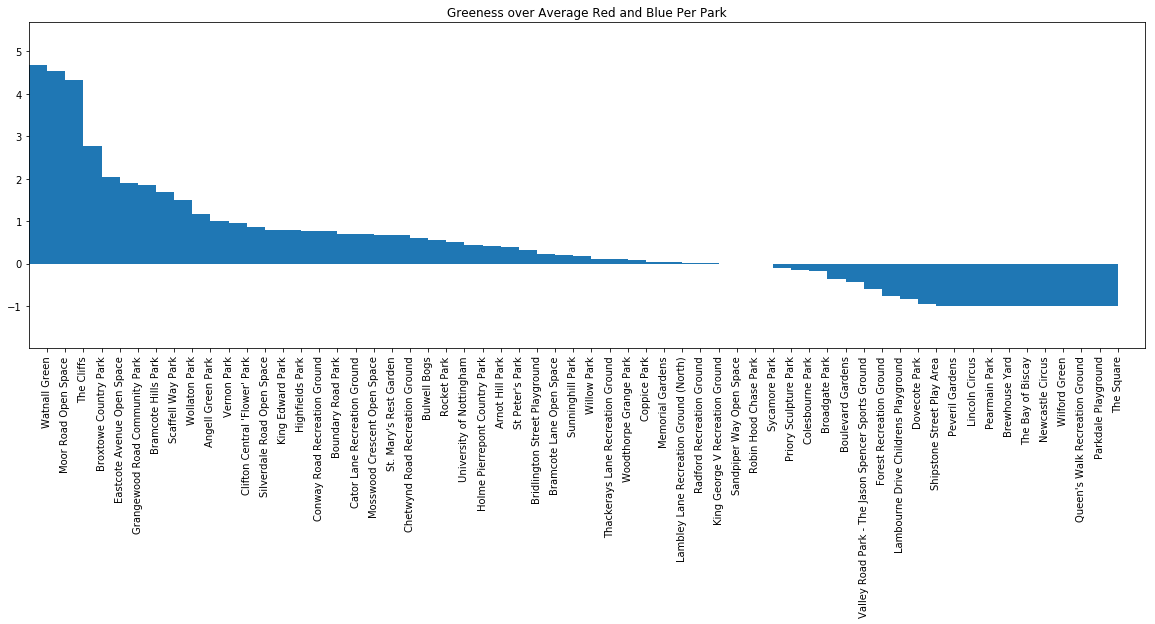

In [30]:
paired = list(zip(tif_file_names,greens))
paired.sort(key=lambda tup: tup[1])
#sorted(paired, key=lambda tup: tup[1])
paired.reverse()
labels = [p[0][8:-4].replace("_"," ") for p in paired]
data = [p[1] for p in paired]
plt.figure(figsize=(20,6))
xlocations = np.array(range(len(paired)))+0.5
width = 1
plt.bar(xlocations, data, width=width)
plt.yticks(range(-1,25,1))
plt.xticks(xlocations+ width/2, labels)
plt.xlim(0, xlocations[-1]+width*2)
plt.ylim(-2,np.max(data)+1)
plt.title("Greeness over Average Red and Blue Per Park")
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
xa = plt.gca()
xa.set_xticklabels(xa.xaxis.get_majorticklabels(), rotation=90)
plt.show()

In [50]:

imgs = [p[0] for p in paired]
for p in imgs[0:35]:
    print (p[8:-4].replace("_"," "))
    display(Image(p.replace('tif','jpg')))


Watnall Green


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Moor Road Open Space


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

The Cliffs


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Broxtowe Country Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Eastcote Avenue Open Space


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Grangewood Road Community Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Bramcote Hills Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Scaffell Way Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Wollaton Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Angell Green Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Vernon Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Clifton Central 'Flower' Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Silverdale Road Open Space


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

King Edward Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Highfields Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Conway Road Recreation Ground


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Boundary Road Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Cator Lane Recreation Ground


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Mosswood Crescent Open Space


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

St. Mary's Rest Garden


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Chetwynd Road Recreation Ground


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Bulwell Bogs


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Rocket Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

University of Nottingham


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Holme Pierrepont Country Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Arnot Hill Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

St Peter's Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Bridlington Street Playground


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Bramcote Lane Open Space


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Sunninghill Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Willow Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Thackerays Lane Recreation Ground


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Woodthorpe Grange Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Coppice Park


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

Memorial Gardens


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

In [58]:
opacity_map = {}
gmax = np.max(greens)
gmin = np.min(greens)
# this is a nonlinear mapping
opacity = [np.clip((float(g**2)-gmin)/float(gmax-gmin),0,1) for g in greens]
for op,name in zip(opacity,paired):
    opacity_map[name]=op

m = Map(
    center=center, 
    zoom=zoom,
    default_tiles = planetMapTiles # Uncomment to use Planet.com basemap
)
dc = DrawControl(
    polygon = polygon,
    rectangle = rectangle
)
# Initialize an action counter variable
actionCount = 0
AOIs = {}

# Register the draw controls handler
def handle_draw(self, action, geo_json):
    # Increment the action counter
    global actionCount
    actionCount += 1
    # Remove the `style` property from the GeoJSON
    geo_json['properties'] = {}
    # Convert geo_json output to a string and prettify (indent & replace ' with ")
    geojsonStr = json.dumps(geo_json, indent=2).replace("'", '"')
    AOIs[actionCount] = json.loads(geojsonStr)
    
# Attach the draw handler to the draw controls `on_draw` event
dc.on_draw(handle_draw)
m.add_control(dc)
m

for p in portland_parks["features"]:
    t = "./parks/"+p["properties"]["name"].replace(" ","_") + ".tif"
    feat = {'geometry':p["geometry"],"properties":{
            'style':{'color': "#00FF00",'fillColor': "#00FF00",'fillOpacity': opacity_map[t],'weight': 1}},
            'type':u"Feature"}
    # convert to geojson
    gjson = GeoJSON(data=feat)
    # add it our map
    m.add_layer(gjson)
m

KeyError: './parks/Cotgrave_Country_Park.tif'